In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import cdist
from distortion import distortion, mean_absolute_distortion
from umap import UMAP
from friendly_guacamole.datasets import (
    Dataset, QiitaMetadata, QiitaTable,
    HMPV13V35,
)
from friendly_guacamole.transforms import (
    UniFrac,
    CLR,
    AsDense,
    RarefactionBIOM,
    PCoA,
    FilterSamples,
)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from itertools import product
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate


In [4]:
RAREFACTION_DEPTH = 1000
dataset = HMPV13V35('data/hmpv13v15')


Files already downloaded and verified


In [5]:
table = dataset['table']
tree = dataset['tree']


In [6]:
preprocessing = Pipeline([
    ('filter_samples', FilterSamples(RAREFACTION_DEPTH))
])

table = preprocessing.fit_transform(table)

In [7]:
table.sum('sample').shape

(8280,)

In [8]:
dm_pipeline = Pipeline([
    ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
    ('unifrac', UniFrac(dataset.apply('tree', 'path'))),
])
dm = dm_pipeline.fit_transform(table)

In [9]:
metadata = dataset['metadata'].set_index('sample_name')
y = metadata.loc[table.ids('sample')]


In [10]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory'],
      dtype='object')

One component

In [11]:
pcoa_transform = PCoA(metric='precomputed')
X = pcoa_transform.fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.8850602648772693 and the largest is 412.68657539808237.
  warn(


In [42]:
U1 = UMAP(metric='precomputed', n_components=1,
          n_neighbors=800,
          min_dist=1,
          random_state=501,
          ).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Two component

In [26]:
X.shape

(8280, 8280)

In [51]:
U2 = UMAP(metric='precomputed', n_components=2,
          n_neighbors=800,
          min_dist=1,
          random_state=521,
          ).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [52]:
U3 = UMAP(metric='precomputed', n_components=3,
          n_neighbors=800,
          min_dist=1,
          random_state=614,
          ).fit_transform(dm)


/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [56]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []
    
    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)
        
    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

In [57]:
y.columns

Index(['body_habitat', 'body_product', 'body_site', 'bodysite', 'description',
       'dna_extracted', 'elevation', 'env', 'env_biome', 'env_feature',
       'env_material', 'env_package', 'geo_loc_name', 'host_common_name',
       'host_scientific_name', 'host_subject_id', 'host_taxid', 'latitude',
       'longitude', 'physical_specimen_location',
       'physical_specimen_remaining', 'psn', 'public', 'qiita_study_id',
       'sample_type', 'scientific_name', 'sequencecenter', 'taxon_id', 'title',
       'animations_gradient', 'animations_trajectory', 'custom_body_site'],
      dtype='object')

In [58]:
y['body_habitat'].unique()

array(['UBERON:skin', 'UBERON:vagina', 'UBERON:feces',
       'UBERON:oral cavity', 'UBERON:saliva'], dtype=object)

In [121]:
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:tooth', 'UBERON:tooth', y['body_habitat'])
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:skin of elbow', 'UBERON:skin of elbow', y['custom_body_site'])
y['custom_body_site'] = np.where(y['body_site'] == 'UBERON:skin of external ear', 'UBERON:skin of external ear', y['custom_body_site'])
y['custom_body_site'] = np.where(y['custom_body_site'] == 'UBERON:skin', 'UBERON:skin other', y['custom_body_site'])

In [122]:
pc1_varexpl = pcoa_transform.ordination_.proportion_explained[0]
pc2_varexpl = pcoa_transform.ordination_.proportion_explained[1]
pc3_varexpl = pcoa_transform.ordination_.proportion_explained[2]

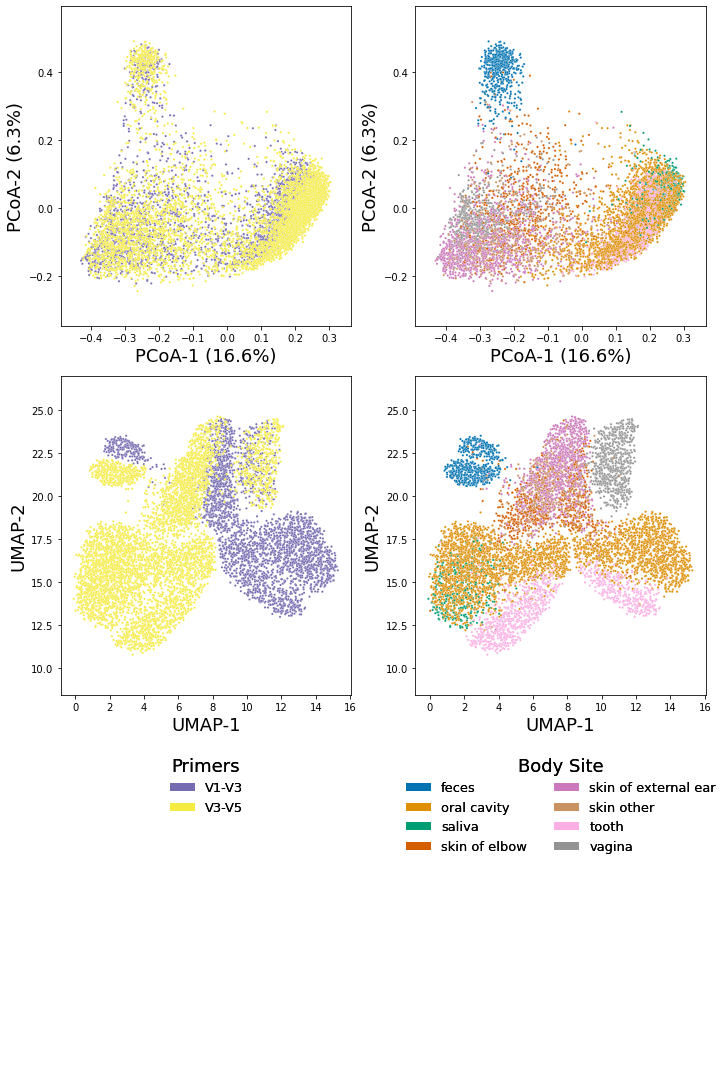

In [123]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

hue_var = 'custom_body_site'
hue_var_order = list(sorted(y[hue_var].unique().tolist()))
var_order = [1927, 1928]
var_map = {1927: 'V1-V3', 1928: 'V3-V5'}


study_palette = ['#756bb1', '#f5ec42']
body_site_palette = 'colorblind'
axis_label_size = 18


g3 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    ax=axs[0, 0],
    palette=study_palette,
    s=5,
    legend=False,
)
g3.set_xlabel(f'PCoA-1 ({pc1_varexpl:.1%})', fontsize=axis_label_size)
g3.set_ylabel(f'PCoA-2 ({pc2_varexpl:.1%})', fontsize=axis_label_size)
g3.set_aspect('equal', 'datalim')

g4 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    palette=study_palette,
    ax=axs[1, 0],
    s=5,
    legend=False,
)
g4.set_xlabel('UMAP-1', fontsize=axis_label_size)
g4.set_ylabel('UMAP-2', fontsize=axis_label_size)
g4.set_aspect('equal', 'datalim')

g5 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    ax=axs[0, 1],
    palette=body_site_palette,
    s=5,
    legend=False
)
g5.set_xlabel(f'PCoA-1 ({pc1_varexpl:.1%})', fontsize=axis_label_size)
g5.set_ylabel(f'PCoA-2 ({pc2_varexpl:.1%})', fontsize=axis_label_size)
g5.set_aspect('equal', 'datalim')

g6 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    palette=body_site_palette,
    ax=axs[1, 1],
    s=5,
    legend=False,
)
g6.set_xlabel('UMAP-1', fontsize=axis_label_size)
g6.set_ylabel('UMAP-2', fontsize=axis_label_size)
g6.set_aspect('equal', 'datalim')

g7 = axs[2, 0]
g7.axis('off')
add_legend(g7, study_palette, [var_map[var] for var in var_order],
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='upper center',
               fontsize=13, ncol=1, framealpha=0.0, 
               title='Primers',
               title_fontsize=axis_label_size,
           )
)

g9 = axs[2, 1]
g9.axis('off')
varmap = pd.Series(hue_var_order).str.replace('UBERON:', '')
add_legend(g9, body_site_palette, varmap.tolist(),
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='upper center',
               fontsize=13, ncol=2, framealpha=0.0, 
               title='Body Site',
               title_fontsize=axis_label_size,
           )
)


plt.tight_layout()
plt.savefig('results/hmp-body-site-full-panel-batch-effect.png', dpi=300)
plt.show()

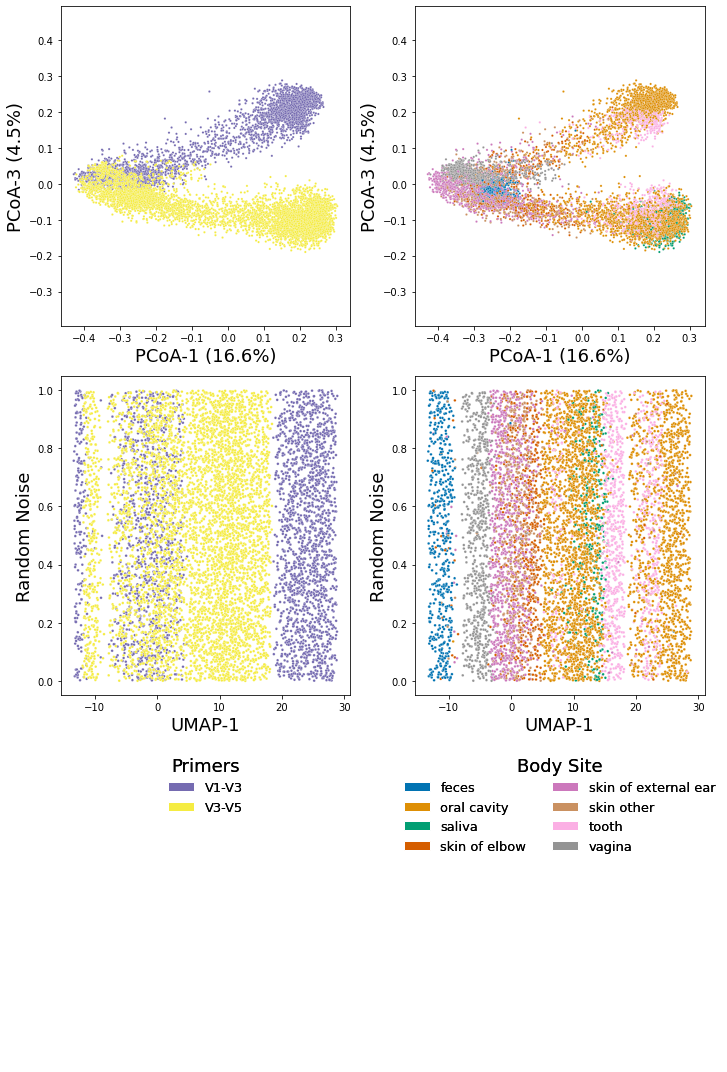

In [124]:
noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

hue_var = 'custom_body_site'
hue_var_order = list(sorted(y[hue_var].unique().tolist()))
var_order = [1927, 1928]
var_map = {1927: 'V1-V3', 1928: 'V3-V5'}


study_palette = ['#756bb1', '#f5ec42']
body_site_palette = 'colorblind'
axis_label_size = 18
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC3'],
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    ax=axs[0, 0],
    palette=study_palette,
    s=5,
    legend=False,
)
g0.set_aspect('equal', 'datalim')
g0.set_xlabel('PCoA-1', fontsize=axis_label_size)
g0.set_ylabel('PCoA-3', fontsize=axis_label_size)
g0.set_xlabel(f'PCoA-1 ({pc1_varexpl:.1%})', fontsize=axis_label_size)
g0.set_ylabel(f'PCoA-3 ({pc3_varexpl:.1%})', fontsize=axis_label_size)

g1 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC3'],
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    ax=axs[0, 1],
    palette=body_site_palette,
    s=5,
    legend=False,
)
g1.set_aspect('equal', 'datalim')
g1.set_xlabel(f'PCoA-1 ({pc1_varexpl:.1%})', fontsize=axis_label_size)
g1.set_ylabel(f'PCoA-3 ({pc3_varexpl:.1%})', fontsize=axis_label_size)

g2 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    palette=study_palette,
    hue=y['qiita_study_id'].tolist(),
    hue_order=var_order,
    s=7,
    ax=axs[1, 0],
    legend=False,
)
g2.set_xlabel('UMAP-1', fontsize=axis_label_size)
g2.set_ylabel('Random Noise', fontsize=axis_label_size)

g7 = axs[2, 0]
g7.axis('off')
add_legend(g7, study_palette, [var_map[var] for var in var_order],
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='upper center',
               fontsize=13, ncol=1, framealpha=0.0,
               title='Primers',
               title_fontsize=axis_label_size,
           )
)

g9 = axs[2, 1]
g9.axis('off')
varmap = pd.Series(hue_var_order).str.replace('UBERON:', '')
add_legend(g9, body_site_palette, varmap.tolist(),
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='upper center',
               fontsize=13, ncol=2, framealpha=0.0,
               title='Body Site',
               title_fontsize=axis_label_size,
           )
)

g8 = sns.scatterplot(
    x=pd.Series(U1[:, 0], name='UMAP-1'),
    y=noise_like,
    palette=body_site_palette,
    hue=y[hue_var].tolist(),
    hue_order=hue_var_order,
    s=7,
    ax=axs[1, 1],
    legend=False,
)
g8.set_xlabel('UMAP-1', fontsize=axis_label_size)
g8.set_ylabel('Random Noise', fontsize=axis_label_size)

plt.tight_layout()
plt.savefig('results/hmp-body-site-supplemental-panel-batch-effect.png',
            dpi=300)
plt.show()

In [125]:
embeddings_X = [
    {
        'ndim': 1,
        'X': pd.DataFrame(X['PC1']),
        'name': 'PCoA'
    },
    {
        'ndim': 2,
        'X': X[['PC1', 'PC2']],
        'name': 'PCoA'
    },
    {
        'ndim': 3,
        'X': X[['PC1', 'PC2', 'PC3']],
        'name': 'PCoA',
    },
    {
        'ndim': 1,
        'X': U1,
        'name': 'UMAP'
    },
    {
        'ndim': 2,
        'X': U2,
        'name': 'UMAP'
    },
    {
        'ndim': 3,
        'X': U3,
        'name': 'UMAP'
    },
]


In [110]:
targets = ['qiita_study_id', 'body_habitat']

ml_scores = []
for target_var, emb in product(targets, embeddings_X):
    model = KNeighborsClassifier()
    scores = cross_validate(model, emb['X'], y[target_var], cv=10)
    score = sum(scores['test_score']) / 10
    # score = model.score(test_X, test_y)
    ml_scores.append({
        'ndim': emb['ndim'],
        'name': emb['name'],
        'target': target_var,
        'test_accuracy': score,
        'scores': scores,
    })


In [111]:
pd.DataFrame(ml_scores).drop('scores', axis=1).sort_values(
    ['target', 'test_accuracy']
)


,ndim,name,target,test_accuracy
6,1,PCoA,body_habitat,0.753019
7,2,PCoA,body_habitat,0.857126
8,3,PCoA,body_habitat,0.874275
9,1,UMAP,body_habitat,0.931280
10,2,UMAP,body_habitat,0.936111
11,3,UMAP,body_habitat,0.945169
0,1,PCoA,qiita_study_id,0.547222
1,2,PCoA,qiita_study_id,0.575242
3,1,UMAP,qiita_study_id,0.805676
2,3,PCoA,qiita_study_id,0.896135
